In [1]:
import re
import json
import nltk
import string
import random
import pathlib
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

In [2]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [3]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

# **Preprocessing Teks**

In [4]:
replace = [
    ['ibu', ['ibuku', 'mami', 'mama']],
    ['ayah', ['ayahku', 'papa', 'daddy']],
    ['saudara', ['adikku', 'adek', 'kakakku', 'koko', 'cece']],
    ['teman', ['temanku']],
    ['meninggal', ['mati']]
]

In [5]:
def preprocess_text(kalimat):
  filtered = re.sub(r'[^\w\d\s]', '', kalimat.lower())
  words = word_tokenize(filtered)

  clean_word = []
  for word in words:
    replaced = False
    for replacement, target in replace:
      if word in target:
        clean_word.append(replacement)
        replaced = True
    if not replaced:
      clean_word.append(word)

  return ' '.join(clean_word)


# **Reading Train & Val Dataset**

In [9]:
with open('/content/Mental Health Conversational.json', 'r') as content:
  chatbot = json.load(content)
data = pd.DataFrame(chatbot['intents'])

In [10]:
dictionary = {"tag":[], "patterns":[], "responses":[]}
for i in range (len(data)):
  pattern = data[data.index==i]['patterns'].values[0]
  response = data[data.index==i]['responses'].values[0]
  tag = data[data.index==i]['tag'].values[0]
  for j in range (len(pattern)):
    dictionary['tag'].append(tag)
    dictionary['patterns'].append(preprocess_text(pattern[j]))
    dictionary['responses'].append(response)
data = pd.DataFrame.from_dict(dictionary)
data

,tag,patterns,responses
0,greeting,hai,[Halo! Selamat bertemu denganmu. Bagaimana kab...
1,greeting,halo,[Halo! Selamat bertemu denganmu. Bagaimana kab...
2,greeting,hai apa kabar,[Halo! Selamat bertemu denganmu. Bagaimana kab...
3,greeting,hi,[Halo! Selamat bertemu denganmu. Bagaimana kab...
4,greeting,assalamualaikum,[Halo! Selamat bertemu denganmu. Bagaimana kab...
...,...,...,...
212,fact_28,bagaimana saya bisa menjaga hubungan sosial ba...,"[Banyak orang yang sendirian saat ini, tapi ki..."
213,fact_29,apa perbedaan antara kecemasan dan stress,[Stres dan kecemasan sering digunakan secara b...
214,fact_29,perbedaan kecemasan dan stress,[Stres dan kecemasan sering digunakan secara b...
215,fact_30,apa perbedaan antara kesedihan dan depresi,[Kesedihan merupakan reaksi normal terhadap ke...


In [11]:
with open('/content/Validation_Conversation.json', 'r') as content:
  val_chatbot = json.load(content)
val_data = pd.DataFrame(val_chatbot['intents'])


In [12]:
dictionary = {"tag":[], "patterns":[]}
for i in range (len(val_data)):
  pattern = val_data[val_data.index==i]['patterns'].values[0]
  tag = val_data[val_data.index==i]['tag'].values[0]
  for j in range (len(pattern)):
    dictionary['tag'].append(tag)
    dictionary['patterns'].append(preprocess_text(pattern[j]))
val_data = pd.DataFrame.from_dict(dictionary)
val_data

,tag,patterns
0,greeting,halo
1,greeting,hai apa kabar
2,greeting,hi
3,morning,pagi
4,afternoon,siang
...,...,...
111,fact_26,apa yang harus saya lakukan jika saya khawatir...
112,fact_27,bagaimana saya tahu kalau saya tidak sehat
113,fact_28,bagaimana saya bisa menjaga hubungan sosial ba...
114,fact_29,perbedaan kecemasan dan stress


In [13]:
# Training
data['tag'].unique()

array(['greeting', 'morning', 'afternoon', 'evening', 'night', 'goodbye',
       'thanks', 'about', 'skill', 'creation', 'help', 'sad', 'stressed',
       'worthless', 'depressed', 'happy', 'casual', 'anxious',
       'not-talking', 'sleep', 'scared', 'death', 'understand', 'done',
       'suicide', 'hate-you', 'hate-me', 'default', 'jokes', 'repeat',
       'wrong', 'stupid', 'location', 'something-else', 'ask', 'problem',
       'no-approach', 'learn-more', 'user-agree', 'meditation',
       'user_meditation', 'hugu_useful', 'user-advice',
       'learn_mental_health', 'mental_health_fact', 'fact_1', 'fact_2',
       'fact_3', 'fact_4', 'fact_5', 'fact_6', 'fact_7', 'fact_8',
       'fact_9', 'fact_10', 'fact_11', 'fact_12', 'fact_13', 'fact_14',
       'fact_15', 'fact_16', 'fact_17', 'fact_18', 'fact_19', 'fact_20',
       'fact_21', 'fact_22', 'fact_23', 'fact_24', 'fact_25', 'fact_26',
       'fact_27', 'fact_28', 'fact_29', 'fact_30'], dtype=object)

In [14]:
# Validation
val_data['tag'].unique()

array(['greeting', 'morning', 'afternoon', 'evening', 'night', 'goodbye',
       'thanks', 'about', 'skill', 'creation', 'help', 'sad', 'stressed',
       'worthless', 'depressed', 'happy', 'casual', 'anxious',
       'not-talking', 'sleep', 'scared', 'death', 'understand', 'done',
       'suicide', 'hate-you', 'hate-me', 'default', 'jokes', 'repeat',
       'wrong', 'stupid', 'location', 'something-else', 'ask', 'problem',
       'no-approach', 'learn-more', 'user-agree', 'meditation',
       'user_meditation', 'hugu_useful', 'user-advice',
       'learn_mental_health', 'mental_health_fact', 'fact_1', 'fact_2',
       'fact_3', 'fact_4', 'fact_5', 'fact_6', 'fact_7', 'fact_8',
       'fact_9', 'fact_10', 'fact_11', 'fact_12', 'fact_13', 'fact_14',
       'fact_15', 'fact_16', 'fact_17', 'fact_18', 'fact_19', 'fact_20',
       'fact_21', 'fact_22', 'fact_23', 'fact_24', 'fact_25', 'fact_26',
       'fact_27', 'fact_28', 'fact_29', 'fact_30'], dtype=object)

# **Tokenizing Train and Validation Pattern & Tag**

**Adding Word Dictionary**

In [15]:
with open('/content/word_dict.json', 'r') as f:
  json_dict = json.load(f)
tokenizer_json=json_dict.keys()

tokenizer = Tokenizer(oov_token='<OOV>')
tokenizer.fit_on_texts(tokenizer_json)

word_index = tokenizer.word_index
print(len(word_index))

18727


Shuffling dataset for better training (*hopefully*)

In [16]:
data = shuffle(data)
val_data = shuffle(val_data)

In [17]:
label_encode = LabelEncoder()

tokenizer.fit_on_texts(data['patterns'])
tokenizer.fit_on_texts(val_data['patterns'])

# Training Set
pattern_train = tokenizer.texts_to_sequences(data['patterns'])
x_train = pad_sequences(pattern_train, padding='post', maxlen=12, truncating='pre')
print("Training Input Shape : ", x_train.shape)
print(len(x_train[0]))

x_label = label_encode.fit_transform(data['tag'])
print("Training Label Shape : ", x_label.shape)
print("Num of classes: ", len(np.unique(x_label)))

Training Input Shape :  (217, 12)
12
Training Label Shape :  (217,)
Num of classes:  75


In [18]:
# Validation Set
pattern_val = tokenizer.texts_to_sequences(val_data['patterns'])
y_train = pad_sequences(pattern_val, padding='post', maxlen=12, truncating='pre')
print("Validation Input Shape : ", y_train.shape)
print(len(y_train[0]))

y_label = label_encode.fit_transform(val_data['tag'])
print("Validation Label Shape : ",y_label.shape)
print("Num of classes: ", len(np.unique(y_label)))

Validation Input Shape :  (116, 12)
12
Validation Label Shape :  (116,)
Num of classes:  75


In [19]:
vocabulary = len(tokenizer.word_index)
print("Number unique word : ",vocabulary)
print("Output Length : ", label_encode.classes_.shape[0])


Number unique word :  18764
Output Length :  75


Converting known word/patterns from dictionary, train and validation dataset

In [20]:
word_dictionary = {item[0]: item[1] for item in tokenizer.word_index.items()}
with open('tokenizer_chatbot_dict.json', 'w') as json_file:
  json.dump(word_dictionary, json_file, indent=4)

Converting tag into json

In [21]:
leDecode = LabelEncoder()
leDecode.fit(val_data['tag'])
name_mapping = dict(zip(leDecode.classes_, leDecode.transform(leDecode.classes_)))
transformed = leDecode.transform(leDecode.classes_).tolist()
name_mapping = dict(zip(leDecode.classes_, transformed))
with open('label_decoder.json', 'w') as json_file:
  json.dump(name_mapping, json_file, indent=4)

# **Embedding** **Glove**

In [22]:
# !rm -f glove.6B.zip
!wget https://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2023-12-21 15:25:55--  https://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-12-21 15:25:56--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  5.16MB/s    in 2m 39s  

2023-12-21 15:28:36 (5.17 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflatin

In [23]:
glove_dir = "/content/glove.6B.100d.txt"
embeddings_index = {}
file_ = open(glove_dir, encoding='utf8')
for line in file_:
  arr = line.split()
  single_word = arr[0]
  w = np.asarray(arr[1:],dtype='float32')
  embeddings_index[single_word] = w
file_.close()
print(len(embeddings_index))

400000


In [24]:
max = vocabulary + 1
word_index =tokenizer.word_index
embedding_mat = np.zeros((max, 100)).astype(object)
for word, i in word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    embedding_mat[i] = embedding_vector

# **Model Architecture, Chatbot Test, Plotting and Training Model**

In [25]:
def chatbot_test():
  while True:
    user_input = input("User: ").lower()
    pattern_test=preprocess_text(user_input)
    pattern_test = tokenizer.texts_to_sequences([pattern_test])
    x_test = pad_sequences(pattern_test, x_train.shape[1])

    prediction = model.predict(x_test)[0]
    label = label_encode.inverse_transform([np.argmax(prediction)])[0]
    response = data[data['tag'] == label]['responses'].values[0]
    print("Label:",label)
    print("Chatbot: ", format(random.choice(response)))
    if label=='goodbye' or label=='thanks':
      break

In [26]:
def plot_training_history(history):
    # Plotting training accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy', color='blue')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='green')
    plt.legend(loc='lower right')
    plt.title('Accuracy')
    plt.ylim(0, 1.0)

    # Plotting training loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss', color='orange')
    plt.plot(history.history['val_loss'], label='Validation Loss', color='yellow')
    plt.legend(loc='upper right')
    plt.title('Loss')
    plt.ylim(0, 4.0)

    # Display the plots
    plt.show()


In [32]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_length=x_train.shape[1], input_dim=vocabulary+1, output_dim = 100, mask_zero=True,
                              weights=[embedding_mat], trainable=False),
    tf.keras.layers.Dropout(0.2),

    # tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128, return_sequences=True)),
    # tf.keras.layers.LayerNormalization(),
    # tf.keras.layers.Dropout(0.2),
    # tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128, return_sequences=False)),
    # tf.keras.layers.LayerNormalization(),
    # tf.keras.layers.Dropout(0.2),

    tf.keras.layers.GRU(128, return_sequences=True, reset_after=False),
    tf.keras.layers.LayerNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.GRU(128, return_sequences=False, reset_after=False),
    tf.keras.layers.LayerNormalization(),
    tf.keras.layers.Dropout(0.2),


    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.LayerNormalization(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LayerNormalization(),
    tf.keras.layers.Dense(len(np.unique(x_label)), activation='softmax')
])

model.summary()
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 12, 100)           1876500   
                                                                 
 dropout_4 (Dropout)         (None, 12, 100)           0         
                                                                 
 gru_2 (GRU)                 (None, 12, 128)           87936     
                                                                 
 layer_normalization_4 (Lay  (None, 12, 128)           256       
 erNormalization)                                                
                                                                 
 dropout_5 (Dropout)         (None, 12, 128)           0         
                                                                 
 gru_3 (GRU)                 (None, 128)               98688     
                                                      

In [28]:
# Callback function to stop training when the accuracy is above 90%
# and validation accuracy above 90%
class MyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') > 0.9 and logs.get('val_accuracy') > 0.8:
            self.model.stop_training = True

In [33]:
history = model.fit(x_train, x_label, validation_data=(y_train, y_label),
                    batch_size=32, epochs=1000, callbacks=[MyCallback()])

Epoch 1/1000
7/7 [==============================] - 8s 204ms/step - loss: 4.7539 - accuracy: 0.0184 - val_loss: 3.9654 - val_accuracy: 0.0776
Epoch 2/1000
7/7 [==============================] - 1s 100ms/step - loss: 4.0306 - accuracy: 0.1014 - val_loss: 3.3747 - val_accuracy: 0.2069
Epoch 3/1000
7/7 [==============================] - 1s 133ms/step - loss: 3.6776 - accuracy: 0.1567 - val_loss: 3.0052 - val_accuracy: 0.3017
Epoch 4/1000
7/7 [==============================] - 1s 126ms/step - loss: 3.3850 - accuracy: 0.1935 - val_loss: 2.6437 - val_accuracy: 0.3362
Epoch 5/1000
7/7 [==============================] - 1s 126ms/step - loss: 3.0154 - accuracy: 0.2765 - val_loss: 2.3699 - val_accuracy: 0.4483
Epoch 6/1000
7/7 [==============================] - 1s 114ms/step - loss: 2.7775 - accuracy: 0.3594 - val_loss: 2.1447 - val_accuracy: 0.4483
Epoch 7/1000
7/7 [==============================] - 0s 68ms/step - loss: 2.5754 - accuracy: 0.4194 - val_loss: 1.9638 - val_accuracy: 0.4914
Epoch 8

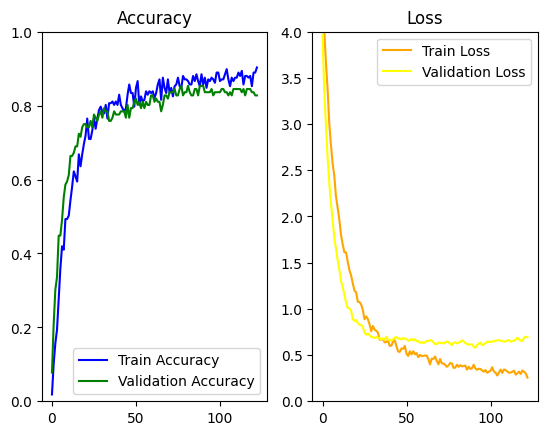

In [34]:
plot_training_history(history)

# **Chatbot Testing**

In [37]:
chatbot_test()

User: halo
1/1 [==============================] - 0s 29ms/step
Label: greeting
Chatbot:  Halo, senang melihat Anda kembali. Apa yang terjadi di duniamu sekarang?
User: aku harus panggil kamu apa
1/1 [==============================] - 0s 29ms/step
Label: about
Chatbot:  Kamu bisa memanggilku Pandora.
User: kamu bisa ngapain aja
1/1 [==============================] - 0s 30ms/step
Label: skill
Chatbot:  Saya dapat memberikan nasihat umum mengenai kecemasan dan depresi, menjawab pertanyaan terkait kesehatan mental, dan melakukan percakapan sehari-hari. Perlu diingat bahwa saya bukan sebagai pengganti ahli kesehatan mental.
User: siapa yang menciptakanmu
1/1 [==============================] - 0s 36ms/step
Label: creation
Chatbot:  Saya dilatih tentang kumpulan data teks menggunakan Deep Learning & Natural Language Processing techniques
User: aku ingin belajar tentang kesehatan mental
1/1 [==============================] - 0s 28ms/step
Label: learn_mental_health
Chatbot:  Oh itu sangat bagus